In [18]:
import pandas as pd
import wget
import os
import lmfit
from lmfit.models import StepModel, ExponentialModel, PolynomialModel


fname = 'time_series_19-covid-Confirmed.csv'

if os.path.exists(fname):
    os.remove(fname)

ddir = 'data/'
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
ff = wget.download(url)
print (ff)
assert ff == fname, f'File name retrieved {ff} changed name? {fname}'

dd = pd.read_csv(ff)

## Data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series



time_series_19-covid-Confirmed.csv


In [ ]:
dd

In [18]:
dd['Country/Region'].unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'San Marino', 'Belarus', 'Iceland', 'Lithuania',
       'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile',
       'Jordan', 'Ukraine', 'Hungary', 'Liechtenstein', 'Poland',
       'Tunisia', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa',
       'Bhutan', 'Cameroon', 'Colombia', 'Costa R

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
47,NaN,New Zealand,-40.9006,174.886,0,0,0,0,0,0,...,5,5,5,5,5,5,6,8,8,12


[ 1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          2.
  2.          3.          3.          3.          3.82842712  3.82842712
  4.60555128  5.79583152  5.79583152  7.55743852  8.81024968  9.60232527
 13.4498996  15.17744688 16.42724862]
Logistic Chile 376.77337266959677 74.46103316184444
Exponential Chile 15047.450969464682 81.3868508904413
3rd deg. Polynomial Chile 2258.185168803935 81.49996880850784
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.  

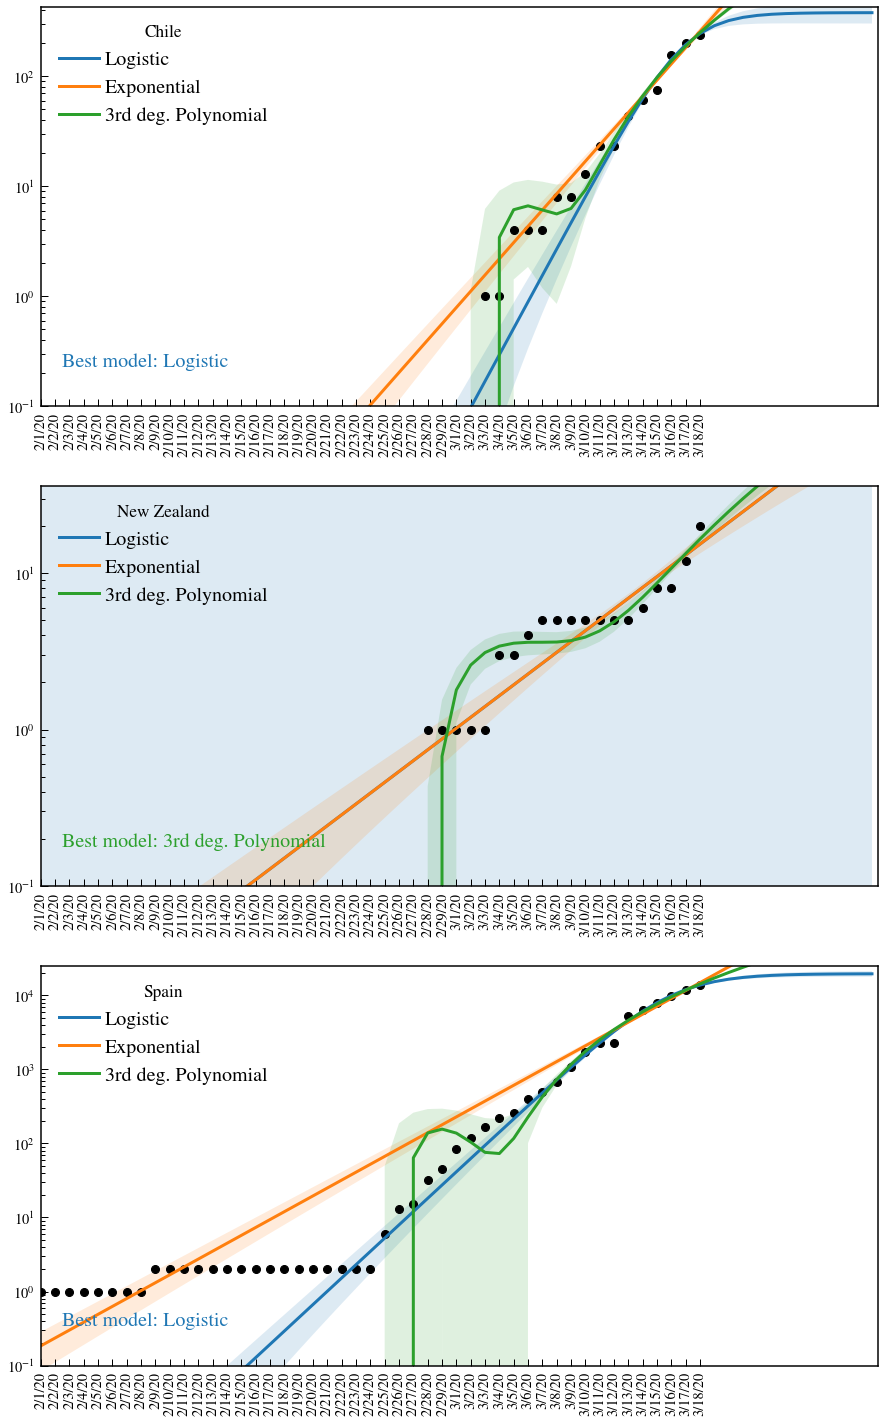

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

countries = ['Chile','New Zealand', 'Spain']
ncountries = len(countries)
models= {'Logistic': StepModel(form='logistic'), 
        'Exponential': ExponentialModel(),
        '3rd deg. Polynomial': PolynomialModel(degree=3)}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, axs = plt.subplots(ncountries,figsize=(15,25))
plt.rcParams['legend.title_fontsize'] = 'xx-large'

for icc,country in enumerate(countries):

    sel = dd['Country/Region'] == country

    dc = dd.loc[sel]
    cols = list(dc.columns)
    dates = cols[4:]

    nn = []
    for i in dates:
        nn.append(dc[i].to_numpy()[0])

    ndata = len(nn)
    nn = np.array(nn)
    #print(nn)    
    err = np.sqrt(nn) + 1
    print (err)

    xx = np.arange(ndata)
    xxx = np.arange(ndata*1.2)
      
    ax = axs[icc]
    ax.plot(np.array(dates),np.array(nn),'ko',markersize=8)
    ax.set_xticks(np.arange(ndata))
    ax.set_xticklabels(dates, rotation='vertical')

    #ax.set_title(f'Numero casos de COVID-19 confirmados en {country}',fontsize=20)
    ax.set_yscale('log')

    icol = 0
    
    ixx = np.where(nn > 10)[0] if country == 'Spain' else np.where(nn > 0)[0]
    bics = []
    mn = []
    for mname, model in models.items():
       
        pars0 = model.guess(nn[ixx], x=xx[ixx])
        out = model.fit(nn[ixx], pars0, x=xx[ixx])
        pars = out.params
        bics.append(out.bic)
        mn.append(mname)
        

#ax.plot(xx, exp_growth(xx, popt[0],popt[1]),'-',linewidth=3)
#plt.plot(xx, out.init_fit, 'k--', label='initial fit')

        dely = out.eval_uncertainty(x=xxx)
        y =  out.eval(pars,x=xxx)        
        ax.plot(xxx,y, '-', label=f'{mname}', color=colors[icol],linewidth=3)
        ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.15)
        icol += 1
        
        print (mname, country, y[len(xx) + 11], bics[-1])
    bic = np.argmin(bics)
    ax.text(0.025,0.1,f'Best model: {mn[bic]}', fontsize=20,
           transform=ax.transAxes, color= colors[bic])

#ax.plot(xx, sigmoid(xx, popt2[0],popt2[1]),'r-',linewidth=3)

    ax.set_xlim([10,ndata*1.2])
    ax.set_ylim([0.1,np.max(nn)*1.8])
#ax.set_xlabel('Fuente de datos: Johns Hopkins CSSE ')
#ax.text(0.0,-0.25, 'Fuente de datos: Johns Hopkins CSSE\n@_amandajw', transform=ax.transAxes, fontsize=20)
#ax.text(0.1,0.75,r'$casos = x_0 e^{t/\tau}$', transform=ax.transAxes,fontsize=15)
#ax.text(0.1,0.7,r'$x_0= 3.6\times 10^{-7}$',transform=ax.transAxes, fontsize=15)
#ax.text(0.1,0.65,r'$\tau= %.2f$'%popt[1], transform=ax.transAxes, fontsize=15)
    ax.legend(title=country, fontsize=20,loc='upper left')
    

plt.show()


#popt2, pcov2 = curve_fit(sigmoid, np.arange(ndata), nn, sigma= err,p0=[.001, .1,.1],absolute_sigma=True)


#print (popt)


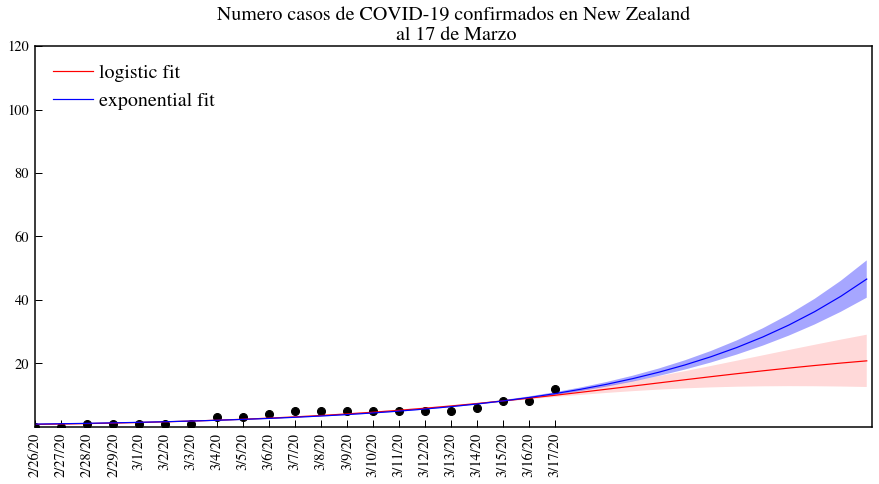

In [69]:




#plt.xticks(rotation=90)

In [41]:
pars_exp

name,value,initial value,min,max,vary
amplitude,8.0768e-21,None,-inf,inf,True
decay,-1.26807118,None,-inf,inf,True
